In [1]:
import torch
import numpy as np
from torch import nn
import tensorly as tl
from tqdm import tqdm
import matplotlib.pyplot
from torch.optim import Adam
from matplotlib import rcParams
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR

In [2]:
from tensor_layer import *

In [3]:
np.random.seed(1337)
torch.manual_seed(1377)

In [4]:
tl.set_backend('pytorch')

In [5]:
train_set = MOA_set("train_X.npy", "train_Y.npy")
val_set = MOA_set("val_X.npy", "val_Y.npy")
test_set = MOA_set("testing_X.npy")

In [6]:
len(train_set), len(val_set), len(test_set)

(17860, 5954, 3982)

In [7]:
BATCH_SIZE = 32

In [8]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class TensorNet(nn.Module): 
    
    def __init__(
        self, order, input_dim, output_dim, rank_tucker=5
    ):
        super(TensorNet, self).__init__()
        self.tensor = NeuralTensorLayer(
            order, input_dim, output_dim, rank_tucker=rank_tucker
        )
        self.bn = nn.BatchNorm1d(output_dim)
        #self.l = nn.Linear(tensor_dim, output_dim)
        self.s = nn.Sigmoid()
        
    def forward(self, x):
        return(self.s(self.bn(self.tensor(x))))
    
    def predict(self, loader, loss=None, train=True, verbose=False, orth_alpha=None):
        Y_hat = []
        mean_loss = 0
        ld = tqdm(loader) if verbose else loader
        for i,a in enumerate(ld):
            d = a[0] if train else a
            c_Y_hat = self.forward(d)
            c_y_hat = c_Y_hat.cpu().data.numpy()
            Y_hat.append(c_y_hat)
            if train:
                loss_val = loss(c_Y_hat, a[1])
                if orth_alpha:
                    loss_val += self.tensor.get_orthogonality_loss()*orth_alpha
                mean_loss += loss_val.cpu().data.numpy()
        return(np.concatenate(Y_hat), mean_loss/i)
    
    def fit(
        self, loader, loss, optimizer, scheduler, n_iter, 
        val_loader, metrics, print_every=10, orth_alpha=0.1, fit_orthogonality=True
    ):
        history = {a: [] for a in metrics}
        history["train_loss"] = []
        history["val_loss"] = []
        for j in tqdm(np.arange(n_iter)):
            mean_loss = 0
            self.train()
            for i,(batch_X, batch_Y) in enumerate(loader):
                optimizer.zero_grad()
                Y_hat = self.forward(batch_X)
                loss_val = loss(Y_hat, batch_Y)
                if fit_orthogonality:
                    loss_val += self.tensor.get_orthogonality_loss()*orth_alpha
                loss_val.backward()
                optimizer.step()
                mean_loss += loss_val.cpu().data.numpy()
            history["train_loss"].append(mean_loss/i)
            self.eval()
            val_Y_hat, val_loss = self.predict(val_loader, loss, orth_alpha=orth_alpha)
            history["val_loss"].append(val_loss)
            val_Y = np.concatenate([a[1].cpu().data.numpy() for a in val_loader])
            for m in metrics:
                history[m].append(metrics[m](val_Y, val_Y_hat))
            if (j+1) % print_every == 0:
                print("epoch#"+str(j))
                print("train loss", history["train_loss"][-1])
                print("val loss", history["val_loss"][-1])
                for m in metrics:
                    print(m, history[m][-1])
            clip_grad_norm_(self.parameters(), 0.3)
            scheduler.step()
        return(history)

In [10]:
model = TensorNet(2, 879, 206).cuda()

/home/bakirillov/HDD/education/Skoltech/MTF/project/skoltech-mtf2020/tensor_layer.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  initializer(self.bias)


In [11]:
loss = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

In [12]:
def colwise_logloss(Y, Y_hat):
    return(-(Y * np.log(Y_hat+10**-6) + (1 - Y) * np.log(1 - Y_hat+10**-6)).mean())

In [13]:
history = model.fit(
    train_loader, loss, optimizer, scheduler, 30, val_loader, 
    {"CWLL": colwise_logloss}, 5
)

epoch#4
train loss 698.245369695848
val loss 473.65775208832116
CWLL 0.12547508
epoch#9
train loss 28.58900260925293
val loss 20.579439501608572
CWLL 0.045604143
epoch#14
train loss 1.1364072124376947
val loss 0.7615447880760315
CWLL 0.026258457
epoch#19
train loss 0.029384492402462336
val loss 0.02438880479143512
CWLL 0.021172386
epoch#24
train loss 0.02048475466715339
val loss 0.02000859271114071
CWLL 0.019852545
epoch#29
train loss 0.019998010027632917
val loss 0.019567438546488042
CWLL 0.019411504



In [16]:
rcParams["figure.figsize"] = (10, 3)

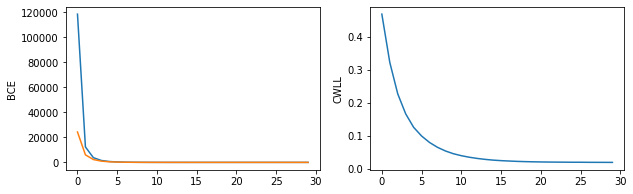

In [17]:
fig, axes = plt.subplots(1,2)
axes[0].plot(history["train_loss"])
axes[0].plot(history["val_loss"])
axes[1].plot(history["CWLL"])
axes[0].set_ylabel("BCE")
axes[1].set_ylabel("CWLL")
plt.show()

In [19]:
history

{'CWLL': [0.46808732,
  0.32199928,
  0.22681428,
  0.16628875,
  0.12547508,
  0.09921541,
  0.07965972,
  0.064983726,
  0.053933572,
  0.045604143,
  0.039667316,
  0.034993965,
  0.03136281,
  0.02850356,
  0.026258457,
  0.024688613,
  0.02353146,
  0.022482341,
  0.02171527,
  0.021172386,
  0.02071931,
  0.020420417,
  0.02020206,
  0.020038506,
  0.019852545,
  0.019843858,
  0.019609611,
  0.0195326,
  0.019477556,
  0.019411504],
 'train_loss': [118628.98945032482,
  12355.774585573477,
  3779.336576728411,
  1533.4168939624635,
  698.245369695848,
  348.6907442974788,
  185.29564404231246,
  99.33156562449685,
  53.38494147023847,
  28.58900260925293,
  15.571608493832278,
  8.561357236677601,
  4.5551069474989365,
  2.3303195985841922,
  1.1364072124376947,
  0.5409109531551279,
  0.2515912859777396,
  0.1114103734012573,
  0.05134084540349181,
  0.029384492402462336,
  0.02297477917678948,
  0.02135297148672056,
  0.020879830891353254,
  0.020631830228031965,
  0.020484754

In [20]:
with open("model.bin", "wb") as oh:
    torch.save(model, oh)

In [22]:
test_predictions = model.predict(test_loader, train=False, verbose=True)[0]

In [27]:
test_predictions.shape

(3982, 206)

In [29]:
import pandas as pd

In [46]:
test_data = pd.read_csv("data/test_features.csv", index_col="sig_id")
targets = pd.read_csv("data/train_targets_scored.csv", index_col="sig_id")

In [41]:
out_df = pd.DataFrame(test_predictions)

In [47]:
test_data.shape, targets.shape

((3982, 875), (23814, 206))

In [45]:
out_df.shape

(3982, 206)

In [49]:
out_df.columns = targets.columns
out_df.index = test_data.index

In [51]:
out_df.to_csv("tensornet_submission.csv")